# 料理の画像からアレルゲンを抽出

まず、`import`の手順を行う。実際実装したところ、<br>
`from keras import ...`を実行する時点においては、<br>
パッケージのバージョンの違いが観測され、<br>
独立した`keras`から`import`することになった。

In [6]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import tensorflow as tf
from keras import datasets, layers, models, losses, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

import tensorflow_datasets as tfds

AUTOTUNE = tf.data.experimental.AUTOTUNE

次に素材を導入する。ただし、ディレクトリを確認し、<br>
分類が正しく認識されているかチェックすること。<br>
出力から見ると、写真が正しく利用可能になった。

In [7]:
# Load local food-101 dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="training"
)

class_names = train_dataset.class_names
num_classes = len(class_names)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


次に中間層を決める。試行を重ねた結果、<br>
中間層の構造及び学習率の設定が以下の通りになった。

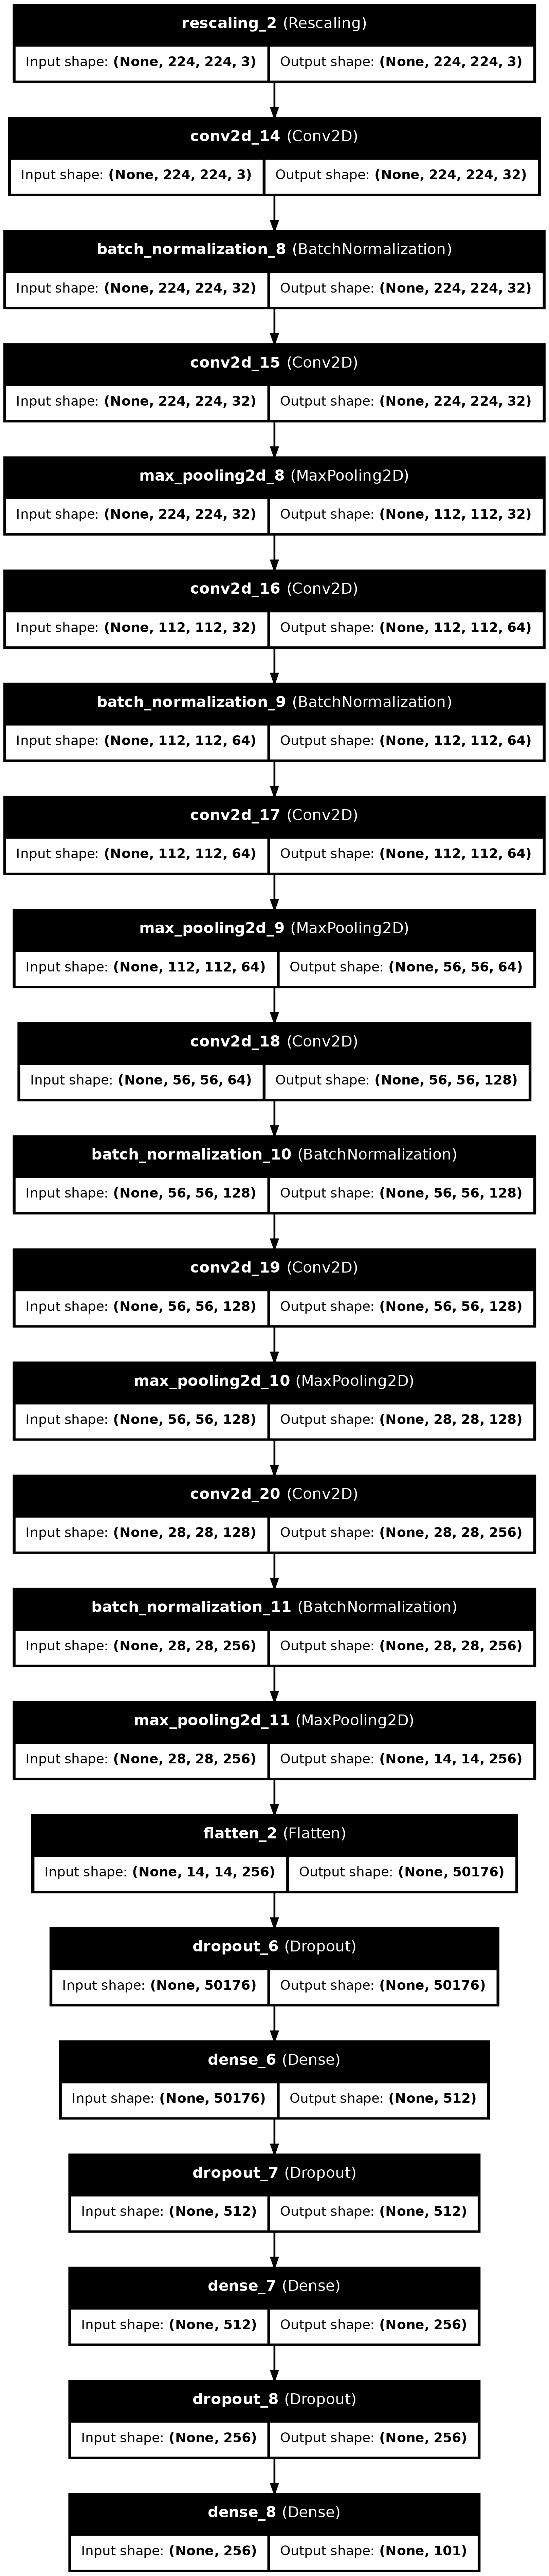

In [8]:
# Build a simple CNN model
model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    # Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.25),

    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

plot_model(model, to_file="cnn_model_plot.png", show_shapes=True, show_layer_names=True)

出来上がりのモデルを用いて、指定された画像を認識することができるはず。<br>
その機能を用意する。

In [9]:
# Predict a single image
def predict_single_image(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    print(f'Predicted class: {predicted_class} (confidence: {confidence:.2f})')

# Load class names from dataset
class_names = train_dataset.class_names

# Example usage
# predict_single_image(model, 'path/to/your/test_image.jpg', class_names)

残りは学習させること。毎回の試行の結果を可視化するために、<br>
`Accuracy`と`Loss`を図示した。

Epoch 1/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0180 - loss: 4.7885

2025-05-12 14:04:13.551844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 52 bytes spill stores, 52 bytes spill loads

2025-05-12 14:04:25.536713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 64 bytes spill stores, 64 bytes spill loads



5050/5050 ━━━━━━━━━━━━━━━━━━━━ 154s 31ms/step - accuracy: 0.0180 - loss: 4.7885 - val_accuracy: 0.0376 - val_loss: 4.6776 - learning_rate: 1.0000e-04
Epoch 2/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149s 29ms/step - accuracy: 0.0220 - loss: 4.6854 - val_accuracy: 0.0125 - val_loss: 4.5447 - learning_rate: 1.0000e-04
Epoch 3/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149s 29ms/step - accuracy: 0.0350 - loss: 4.5258 - val_accuracy: 0.0715 - val_loss: 4.1766 - learning_rate: 1.0000e-04
Epoch 4/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 150s 30ms/step - accuracy: 0.0792 - loss: 4.1634 - val_accuracy: 0.2289 - val_loss: 3.4299 - learning_rate: 1.0000e-04
Epoch 5/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149s 29ms/step - accuracy: 0.1426 - loss: 3.7664 - val_accuracy: 0.2316 - val_loss: 3.3131 - learning_rate: 1.0000e-04
Epoch 6/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149s 30ms/step - accuracy: 0.2068 - loss: 3.4248 - val_accuracy: 0.3164 - val_loss: 2.8483 - learning_rate: 1.0000e-04
Epoch 7/30
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 149

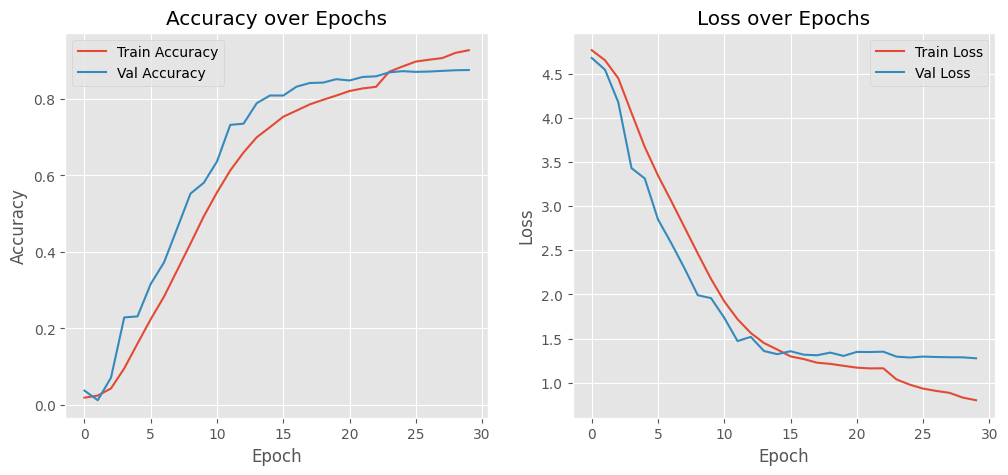

In [11]:
# Train the model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

# Save the model
model.save('food-101_model.keras')
print("✅ Training complete, model saved as 'food-101_model.keras'!")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()